In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import math
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)

In [2]:
'''
Linear Regression README:
Modes:
1. Human Observed Dataset
2. GSC
Feature Type:
a. Feature Concat
b. Feature Subs
'''
mode = 1
subMode = 'b'

In [3]:
# GSC or HOD??
if(mode == 1):
    hum_obs_master_data = pd.read_csv("../HumanObserved-Dataset/HumanObserved-Dataset/HumanObserved-Features-Data/HumanObserved-Features-Data.csv")
    hum_obs_pos_data = pd.read_csv("../HumanObserved-Dataset/HumanObserved-Dataset/HumanObserved-Features-Data/same_pairs.csv")
    hum_obs_neg_data = pd.read_csv("../HumanObserved-Dataset/HumanObserved-Dataset/HumanObserved-Features-Data/diffn_pairs.csv")
elif(mode ==2):
    gsc_master_data = pd.read_csv("../GSC-Dataset/GSC-Dataset/GSC-Features-Data/GSC-Features.csv")
    gsc_pos_data = pd.read_csv("../GSC-Dataset/GSC-Dataset/GSC-Features-Data/same_pairs.csv")
    gsc_neg_data = pd.read_csv("../GSC-Dataset/GSC-Dataset/GSC-Features-Data/diffn_pairs.csv")
    

In [4]:
def create_setting_one(master_data,pos_data):
    raw_data_temp = pd.concat([pos_data.set_index('img_id_A'),master_data.set_index('img_id')],axis=1,join='inner').reset_index()
    raw_data_feature_concat = pd.concat([raw_data_temp.set_index('img_id_B'),master_data.set_index('img_id')],axis=1,join='inner').reset_index()
    if(np.shape(raw_data_feature_concat)[1] < 25):
        raw_data_feature_concat.drop(['Unnamed: 0'],axis=1,inplace=True)
        num_features = 9 + 1
    else:
        num_features = 512+1
    col_rename = ['img_id_B','img_id_A','target']
    for columns in range(1,len(list(raw_data_feature_concat.columns)[3:])+1):
        if(columns < num_features):
            col_rename.append("fa"+str(columns))
        else:
            col_rename.append("fb"+str(columns - num_features+1))
    raw_data_feature_concat.columns = col_rename
    col_rename.append(col_rename.pop(2))
    temp = col_rename[0]
    col_rename[0] = col_rename[1]
    col_rename[1] = temp
    raw_data_feature_concat = raw_data_feature_concat[col_rename]
    return raw_data_feature_concat

def create_setting_two(raw_data_feature_concat):
    raw_data_feature_subs = pd.concat([raw_data_feature_concat.iloc[:,0:2],raw_data_feature_concat.iloc[:,-1]],axis=1,join='inner').reset_index()
    for columns in range(1,int((len(list(raw_data_feature_concat.columns))-3)/2+1)):
        raw_data_feature_subs['fm'+str(columns)] = abs(raw_data_feature_concat['fa'+str(columns)] - raw_data_feature_concat['fb'+str(columns)])
    col_swap = list(raw_data_feature_subs.columns)[1:]
    col_swap.append(col_swap.pop(2))
    raw_data_feature_subs=raw_data_feature_subs[col_swap]
    return raw_data_feature_subs

def representativeClustering(data,sizeOfTheCluster,seed):
    kmeans = KMeans(n_clusters=sizeOfTheCluster, random_state=seed)
    kmeans_data = kmeans.fit_predict(data.iloc[:,data.columns != 'target'])
    data = data.join(pd.DataFrame(kmeans_data,columns=["kmean_cluster_number"]))
    '''
    2D stratified sampling on the target value and the cluster number so that the algorithm which we will 
    implement will have fair chances of learning all types of data.
    '''
    train,test_val = train_test_split(data,test_size = 0.2,stratify=data[["target","kmean_cluster_number"]],random_state=seed)
    val,test = train_test_split(test_val,test_size = 0.5,stratify=test_val[["target","kmean_cluster_number"]],random_state=seed)
    '''
    Cluster number is not required now
    '''
    train = train.drop(["kmean_cluster_number"],axis=1)
    test = test.drop(["kmean_cluster_number"],axis=1)
    val = val.drop(["kmean_cluster_number"],axis=1)

    mu = kmeans.cluster_centers_
    return train,test,val,mu

# Linear Regression Functions Development
def covar(trainData,num_basis):
    ''' 
    Getting the covar over the training data based on number of basics we have implemented
    Changed the spread for Gaussian radial basis function
    '''
    #print("Using Uniform Gaussian radial basis function")
    train_transpose = np.transpose(trainData)
    iden = np.identity(np.shape(train_transpose)[0])
    for i in range(0,np.shape(train_transpose)[0]):
        # EDIT HERE FOR PRECISION AND NON UNIFORM RADIAL BASICS
        iden[i] = np.dot(iden[i],np.dot(2.5,np.var(train_transpose.iloc[i,:])))
    return iden

def genPhi(train,covarMat,num_basis,mu):
    '''
    Getting the Phi based on the covariance and number of basis
    '''
    phiMat = np.zeros((len(train),int(num_basis))) 
    covarMatInv = np.linalg.pinv(covarMat)
    for i in range(0,num_basis):
        for j in range(0,len(train)):
            subsResult = (np.subtract(train.iloc[j,],mu[i,]))
            L = np.dot(np.transpose(subsResult),covarMatInv)
            R = np.dot(L,subsResult)
            phiMat[j][i] = math.exp(-np.dot(0.5,R))
    return phiMat

def updateWeights(weights,phiMat,train_lab,alpha,lam): 
    midT = np.dot(np.transpose(weights),phiMat)
    deltaL = -(np.subtract(train_lab,midT))
    deltaD = np.dot(float(deltaL),phiMat)
    deltaE = np.transpose(np.matrix(deltaD)) + np.dot(lam,weights)

    delta = np.dot(-alpha,deltaE)
    new_weight = weights + delta
    return new_weight

def GetValTest(VAL_PHI,W):
    Y = np.dot(np.transpose(prev_weight),np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

def GetErms(valData,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(valData)):
        sum = sum + math.pow((ValDataAct[i] - valData[i]),2)
        if(int(np.around(valData[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(valData)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(valData)))),math.sqrt(sum/len(valData))

def plotData(log_erms_train,log_erms_val,log_erms_test):
    writePlot('log_erms_train',log_erms_train)
    writePlot('log_erms_val',log_erms_val)
    writePlot('log_erms_test',log_erms_test)
    return True

def writePlot(filename,log):
    df = pd.DataFrame(log)
    ax = df.plot(figsize=(10,15))
    ax.ticklabel_format(useOffset=False)

    plt.savefig(('./'+filename+'.png'),bbox_inches='tight')
    plt.close("all")
    
def epoch_shuffle(train,train_lab,phiMat):
    # Merge
    temp = pd.merge(train.reset_index(),pd.DataFrame(train_lab).reset_index())
    temp.columns.values[-1] = "target"
    temp = pd.merge(temp,pd.DataFrame(phiMat).reset_index())
    temp = temp.sample(frac=1,random_state=431).reset_index().iloc[:,2:]
    if(mode == 1):
        if(subMode == 'a'):
            num_feat = 18
        elif(subMode == 'b'):
            num_feat = 9
    elif(mode == 2):
        if(subMode == 'a'):
            num_feat = 512*2
        elif(subMode == 'b'):
            num_feat = 512
    train = temp.iloc[:,0:num_feat]
    train_lab = np.asarray(temp.iloc[:,num_feat])
    phiMat = np.array(temp.iloc[:,num_feat+1:])
    return train,train_lab,phiMat


In [5]:
if(mode ==1):
    raw_pos_data = create_setting_one(hum_obs_master_data,hum_obs_pos_data)
    raw_neg_data = create_setting_one(hum_obs_master_data,hum_obs_neg_data.sample(len(raw_pos_data),random_state = 444))
    if(subMode == 'b'):
        raw_pos_data = create_setting_two(raw_pos_data)
        raw_neg_data = create_setting_two(raw_neg_data)
        del hum_obs_master_data,hum_obs_pos_data,hum_obs_neg_data
elif(mode == 2):
    # High Memory -> NEED TO FIX
    raw_pos_data = create_setting_one(gsc_master_data,gsc_pos_data)
    raw_neg_data = create_setting_one(gsc_master_data,gsc_neg_data.sample(len(gsc_pos_data)))
    if(subMode == 'b'):
        raw_pos_data = create_setting_two(raw_pos_data)
        raw_neg_data = create_setting_two(raw_neg_data)
        del gsc_master_data,gsc_pos_data,gsc_neg_data

In [6]:
'''
Various Setting Generations
Oversampling = o
Undersampling = u
Perfect = p
'''
sampling = 'o'

In [7]:
'''
Partition Scheme
unseenWriter = true
default = false
'''
partScheme = False
if(partScheme):
    # Unseen Writer partitions
    raw_data_feature_concat_pos[['A','A_imgNo']] = raw_data_feature_concat_pos['img_id_A'].str.extract('(\d\d\d\d)([a-z])', expand=False)
    raw_data_feature_concat_pos[['B','B_imgNo']] = raw_data_feature_concat_pos['img_id_B'].str.extract('(\d\d\d\d)([a-z])', expand=False)
    #raw_data_feature_concat['img_id_A'].str.extract('(?P<writerA>\d\d\d\d)(?P<imageNo>[abcd])', expand=False)
    raw_data_feature_concat_neg[['A','A_imgNo']] = raw_data_feature_concat_neg['img_id_A'].str.extract('(\d\d\d\d)([a-z])', expand=False)
    raw_data_feature_concat_neg[['B','B_imgNo']] = raw_data_feature_concat_neg['img_id_B'].str.extract('(\d\d\d\d)([a-z])', expand=False)
    data = pd.concat([raw_pos_data,raw_neg_data],ignore_index=True)
else:
    data = pd.concat([raw_pos_data,raw_neg_data],ignore_index=True)
data = data.iloc[:,2:np.shape(data)[1]]
    

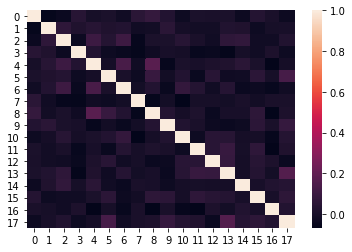

In [153]:
# Get The heatmap of corr to determine the clusters
sns.heatmap(np.corrcoef(raw_pos_data.iloc[:,2:-1],raw_neg_data.iloc[:,2:-1],rowvar=False))

In [9]:
if(mode == 2):
    if(subMode == 'a'):
        M = 9
else:
    M = 9
data = data.sample(frac=1)
train,test,val,mu = representativeClustering(data=data,sizeOfTheCluster=M,seed=421)
if(sampling == 'o'):
    pos = train[train['target'] == 1]
    neg = train[train['target'] == 0]
    train_pos = pd.concat([pos,pos,pos,pos,pos],ignore_index=True)
    train_neg = neg.sample(n=len(pos))
    train = pd.concat([train_pos,train_neg])
    del pos,neg,train_pos,train_neg
train = train.sample(frac=1,random_state=444).reset_index().iloc[:,1:]
train_lab = train.iloc[:,train.columns == 'target']
val_lab = val.iloc[:,val.columns == 'target']
test_lab = test.iloc[:,test.columns == 'target']
train = train.iloc[:,train.columns != 'target']
val = val.iloc[:,val.columns != 'target']
test = val.iloc[:,test.columns != 'target']
#print(data.head())

In [10]:
covarMat = covar(train,M)

In [11]:
#print(" Getting the covar over the training data based on number of basics we have implemented")
#covarMat = covar(train,M)
phiMat = genPhi(train,covarMat,M,mu)
valMat = genPhi(val,covarMat,M,mu)
testMat = genPhi(test,covarMat,M,mu)

In [12]:
np.random.seed(1994)
if(mode == 2):
    if(subMode == 'a'):
        prev_weight = np.zeros((M,1))
else:
    prev_weight = np.matrix(np.random.rand(M,1))
prev_weight

matrix([[0.3887621 ],
        [0.01547099],
        [0.94718274],
        [0.33959462],
        [0.78467214],
        [0.94637165],
        [0.95105546],
        [0.63413822],
        [0.82586132]])

In [13]:
def batchUpdateWeights(weights,phiMat,train_lab,alpha,lam): 
    midT = np.dot(phiMat,weights)
    deltaL = -(np.subtract(train_lab,midT))
    deltaD = np.dot(np.transpose(deltaL),phiMat)
    deltaE = np.transpose(deltaD) + np.dot(lam,prev_weight)

    delta = np.dot(-alpha,deltaE)
    new_weight = weights + delta
    return new_weight

In [ ]:
batchUpdateWeights(prev_weight,phiMat,pd.DataFrame(train_lab),alpha,lam)

In [ ]:
alpha = 0.001
lam = 0.005
if(mode == 2):
    if(subMode == 'a'):
        nprev_weight = np.zeros((M,1))
else:
    nprev_weight = np.matrix(np.random.rand(M,1))
    
while((np.subtract(prev_weight,prev_weight) == np.zeros((M,1))).all()):
    prev_weight = nprev_weight
    nprev_weight = batchUpdateWeights(prev_weight,phiMat,pd.DataFrame(train_lab),alpha,lam) 


In [16]:
VAL_TEST_OUT  = GetValTest(valMat,prev_weight) 
GetErms(np.transpose(VAL_TEST_OUT),np.asarray(val_lab))

('55.69620253164557,0.5810537335457874', 0.5810537335457874)

In [ ]:
train_lab = np.asarray(train_lab)
log_erms_val = np.zeros(300000)
log_erms_train = np.zeros(300000)
log_erms_test = []
np.random.seed(589)
if(mode == 2):
    if(subMode == 'a'):
        prev_weight = np.zeros((M,1))
else:
    prev_weight = np.matrix(np.random.rand(M,1))
'''1 B
alpha = 0.00003
lam = 0.5
sensitivity =  0.001
'''
alpha = 0.05
lam = 0.05
sensitivity =  0.001
pErms_Val = 0
nErms_Val = 10
ptrain_erms = 0
ntrain_erms = 10
epoch = 0
ValAccString = ''
TrainAccString = ''
'''
Logging for ERMS Train and Validate should have graphMode enabled
'''

graphMode = False

while(abs(ntrain_erms - ptrain_erms ) > sensitivity):
    print("Epoch: "+str(epoch))
    print(TrainAccString)
    print(ValAccString)
    for i in range(0,len(train)):
        #print("Iteration: "+str(i))
        prev_weight = updateWeights(prev_weight,phiMat[i],train_lab[i],alpha,lam)
        #-----------------TrainingData Accuracy---------------------#
        #TR_TEST_OUT   = GetValTest(phiMat,prev_weight) 
        #Erms_TR,train_erms       = GetErms(np.transpose(TR_TEST_OUT),np.asarray(train_lab))
        #print ('---------ValidationData Accuracy: ' + Erms_Val + '--------------')
        #VAL_TEST_OUT  = GetValTest(valMat,prev_weight) 
        #Erms_Val,val_erms      = GetErms(np.transpose(VAL_TEST_OUT),np.asarray(val_lab))
        
        
        #---------------TestingData Accuracy---------------------#
        #TEST_OUT      = GetValTest(testMat,prev_weight) 
        #Erms_Test = GetErms(np.transpose(TEST_OUT),np.asarray(test_lab))
        #log_erms_test.append(float(Erms_Test.split(',')[1]))
        if(graphMode):
            log_erms_train[i] = train_erms
            log_erms_val[i] = val_erms
            
    train,train_lab,phiMat = epoch_shuffle(train,train_lab,phiMat)
    
    TR_TEST_OUT   = GetValTest(phiMat,prev_weight)
    ptrain_erms = ntrain_erms
    TrainAccString,ntrain_erms       = GetErms(np.transpose(TR_TEST_OUT),np.asarray(train_lab))
    
    VAL_TEST_OUT  = GetValTest(valMat,prev_weight)
    pErms_Val = nErms_Val
    ValAccString,nErms_Val      = GetErms(np.transpose(VAL_TEST_OUT),np.asarray(val_lab))
    epoch +=1
    #if(epoch >5):
       # pErms_Val = nErms_Val

In [ ]:
plotData(log_erms_train,log_erms_val,log_erms_test)

In [58]:
confusion_matrix(val_lab.iloc[:,0],np.array(np.round(VAL_TEST_OUT.reshape(np.shape(VAL_TEST_OUT)[1],1),0)))

array([[45, 33],
       [37, 43]])

In [59]:
y_true = pd.Series(np.array(val_lab.iloc[:,0]))
y_pred = pd.Series(np.array((np.around(VAL_TEST_OUT, 0))).ravel())

pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
True,,,
0,45,33,78
1,37,43,80
All,82,76,158


In [60]:
y_true = pd.Series(np.array(test_lab.iloc[:,0]))
y_pred = pd.Series(np.array((np.around(TR_TEST_OUT, 0))).ravel())

pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
True,,,
0,39,41,80
1,31,48,79
All,70,89,159
